In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(r'C:\Users\xalvi\Documents\Career\!Data Science Education\Kaggle\Store Sales Forecasting\stores_sales_forecasting.csv', encoding='ISO-8859-1')

In [2]:
#The purpose of this notebook is to determine if there is a relationship between order lead time and customer retention
#Hypothesis: lower lead times in the year 2014 result in higher customer retention in subsequent years

#First I create a series of the lead times between order dates and ship dates
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

#Create new series by subtracting order date from ship date
df['Lead Time'] = df['Ship Date'] - df['Order Date']

#Use dt.days to convert to a day integer
df['Lead Time'] = df['Lead Time'].dt.days

#Confirm series was added and looks as expected
print(df.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
3       6  CA-2014-115812 2014-06-09 2014-06-14  Standard Class    BH-11710   
4      11  CA-2014-115812 2014-06-09 2014-06-14  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Region  \
0      Claire Gute  Consumer  United States        Henderson  ...  South   
1      Claire Gute  Consumer  United States        Henderson  ...  South   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...  South   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...   West   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...   West   

        Product ID   Category Sub-Category  \
0  FUR-BO-10001798  Fu

In [3]:
#Store customers and their longest lead times of 2014 as key-value pairs in a dictionary
customer_dict = dict()
customer_2014_returns = dict()
order_counted = list()

#For loop through data
for i in range(0,len(df['Lead Time'])):
    #Only look at order dates in 2014
    #Additionally, only look at Standard Class (3 days for Standard is typical but very long for First Class)
    if df.iloc[i,2].year == 2014 and df.iloc[i,4] == "Standard Class":
        #Get customer ID
        this_customer = df.iloc[i,5]
        #If this customer is not already in the dict, add them with lead time as their value
        if this_customer not in customer_dict:
            customer_dict[this_customer] = df.iloc[i,21]
            #Store the number of orders for this customer in 2014 in a separate dictionary (for averaging)
            customer_2014_returns[this_customer] = 1
        else:
            #If the customer has multiple orders in 2014, update both dictionaries accordingly (if order was not already counted)
            
            if df.iloc[i,1] not in order_counted:
                #Store orders in a list to ensure no double-counting occurs
                order_counted.append(df.iloc[i,1])
                
                customer_2014_returns[this_customer] += 1

                #Add lead time to value, to be averaged later
                customer_dict[this_customer] += df.iloc[i,21]

#Get average 2014 lead times for each customer by dividing lead time sums (dict values) by stored number of orders
customer_dict = {key: customer_dict[key]/customer_2014_returns[key] for key in customer_dict}

print('Unique shoppers in 2014: ' + str(len(customer_dict)))

Unique shoppers in 2014: 184


In [4]:
#Create a new dictionary identical to the customer_dict with 0 values
customer_return_dict = {key:0 for key in customer_dict.keys()}
order_counted = list()

#Loop through dataframe rows again
for i in range(0,len(df['Lead Time'])):
    #If the customer shopped in 2014 and the current row is not an order from 2014
    if df.iloc[i,5] in customer_dict and df.iloc[i,2].year != 2014:

        #If we did not already count this order, increase the "return" count for this customer by 1
        if df.iloc[i,1] not in order_counted:        
            customer_return_dict[df.iloc[i,5]] += 1
            #Store orders in a list to ensure no double-counting occurs
            order_counted.append(df.iloc[i,1])

#Prepare lists for lead time and customer retention
leadtime_list = list()
retention_list = list()

#Transfer lead times and return counts over to lists for further analysis
for customer in customer_dict:
    
    leadtime_list.append(customer_dict[customer])
    retention_list.append(customer_return_dict[customer])


The slope of the linear regression line is 0.06
The Pearson's correlation coefficient is: 0.04


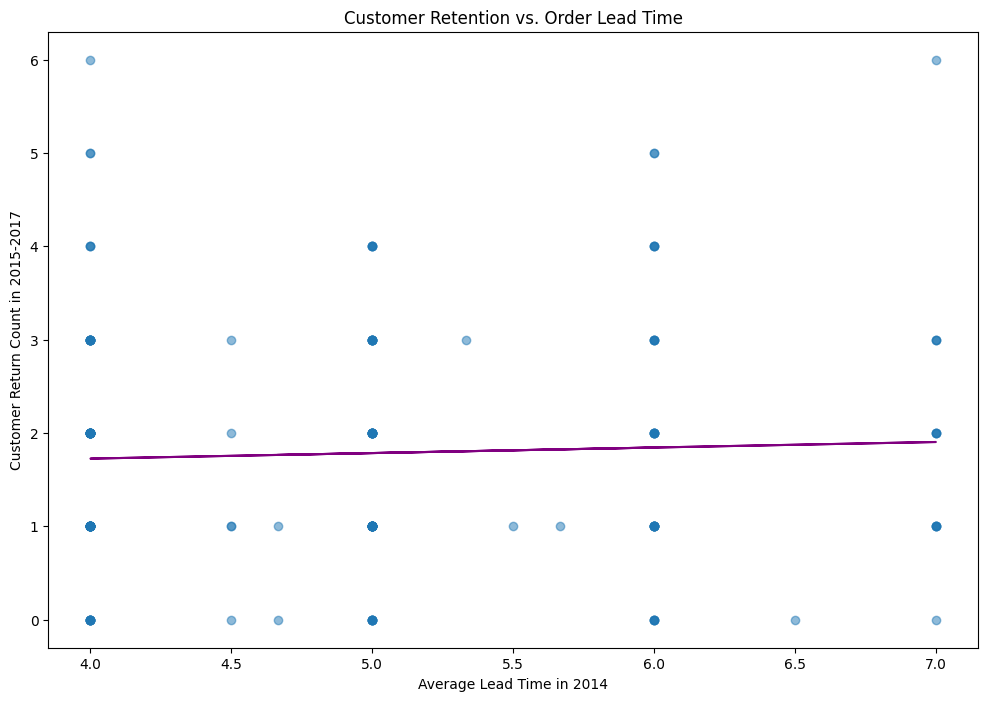

In [5]:
#Perform linear regression
slope, intercept = np.polyfit(leadtime_list, retention_list, 1)

#Use NumPy to get the linear regression slope and intercept values
predicted_return_count = np.polyval([slope, intercept],leadtime_list)
print("The slope of the linear regression line is " + str(round(slope,2)))

#Also calculate the Pearson correlation coefficient to compare against (note: Between 0 and .3 is considered a weak correlation)
corr_coefficient = np.corrcoef(leadtime_list, retention_list)[0,1]
print("The Pearson's correlation coefficient is: " + str(round(corr_coefficient,2)))

#Create scatter plot with regression line
plt.figure(figsize=(12,8))
plt.scatter(leadtime_list, retention_list, alpha = 0.5)
plt.plot(leadtime_list, predicted_return_count, color='purple',label='Fitted Line')
plt.xlabel("Average Lead Time in 2014")
plt.ylabel("Customer Return Count in 2015-2017")
plt.title("Customer Retention vs. Order Lead Time")
plt.show()
